<a href="https://colab.research.google.com/github/harshitharavi26/PP1/blob/main/Resnet_pp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2    
from tqdm import tqdm
import random as random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
imagedetails = []
imagelabels = []
IMG_SIZE=150
gallina_dir='/content/drive/My Drive/pp/gallina'
cane_dir = '/content/drive/My Drive/pp/cane'
mucca_dir = '/content/drive/My Drive/pp/mucca'
pecora_dir = '/content/drive/My Drive/pp/pecora'
#we will take only these 3 because if we include pecora then lot of them are identifying as pecora only 
#see confusion matrix for clarity

In [4]:
def read_image(label,DIR):
    
    for img in tqdm(os.listdir(DIR)):
    #for img in DIR:
        path = os.path.join(DIR,img)
        #checking image type
        _, ftype = os.path.splitext(path)
        if ftype == ".jpeg":
       
            image = cv2.imread(path,cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_AREA)
            imagedetails.append(np.array(image))
            imagelabels.append(str(label))

read_image("gallina",gallina_dir)
read_image("cane",cane_dir)
read_image("mucca",mucca_dir)
read_image("pecora",pecora_dir)

100%|██████████| 990/990 [02:27<00:00,  6.73it/s]


In [5]:
encoder = LabelEncoder()
#converting the images into arrays which will have its intensity values
X = np.array(imagedetails)
print(X)
#divide by 255 is to make the analysis easy because each color 8 plains (2^8==256)
X = X/255
print(X)
print(imagelabels)
#transformig the image labels into integers because it easy to deal with integers compared to strings;
y = encoder.fit_transform(imagelabels)
#dividing into 3 categories
y = to_categorical(y,4)
print(y)
#np.delete(X,1)
#np.delete(X,2)
print(X.shape)
print(y.shape)

[[[[114 134 145]
   [ 69  90  98]
   [ 14  32  38]
   ...
   [ 81 124 121]
   [108 164 160]
   [ 71 139 134]]

  [[ 60  83  94]
   [ 78 103 110]
   [ 74  99 105]
   ...
   [108 151 154]
   [ 83 134 135]
   [ 40 100 100]]

  [[ 37  66  73]
   [ 65  95 101]
   [ 38  69  74]
   ...
   [ 88 131 142]
   [ 91 136 146]
   [ 74 122 129]]

  ...

  [[ 13  43  46]
   [117 143 142]
   [ 46  69  66]
   ...
   [ 61  95 118]
   [ 72 105 128]
   [ 92 123 146]]

  [[  4  31  30]
   [ 44  71  68]
   [ 47  71  66]
   ...
   [ 71 106 129]
   [ 48  81 104]
   [ 66  98 121]]

  [[ 39  70  69]
   [ 16  38  34]
   [ 96 119 114]
   ...
   [ 68 105 127]
   [ 82 116 139]
   [107 139 162]]]


 [[[154 191 195]
   [136 177 186]
   [137 187 197]
   ...
   [252 252 252]
   [252 252 252]
   [253 253 253]]

  [[135 170 177]
   [145 183 193]
   [134 180 192]
   ...
   [255 255 255]
   [254 254 254]
   [253 253 253]]

  [[152 184 191]
   [149 182 195]
   [143 181 195]
   ...
   [248 248 248]
   [254 254 254]
   [253 253

In [6]:
#dividing the entire dataset into training data and validation data
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)
#dividing the training dataset into training and testing
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape
# sum should result in total

((2338, 150, 150, 3),
 (2338, 4),
 (731, 150, 150, 3),
 (731, 4),
 (585, 150, 150, 3),
 (585, 4))

In [7]:
batch_size = 64
epochs = 100
num_classes = y.shape[1]

In [8]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
aug1=ImageDataGenerator(
    rotation_range=30, width_shift_range=0.15,
    height_shift_range=0.15, shear_range=0.15,
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [16]:
from tensorflow.keras.applications import ResNet152V2
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
pre_trained_model = ResNet152V2(input_shape = (150, 150, 3),include_top=False, weights='imagenet')
for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('conv5_block2_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [17]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (4, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [18]:
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [19]:
imagegen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                            rotation_range=60,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              fill_mode='reflect')
imagegen.fit(X_train)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath = 'cnn3.hdf5',monitor='val_accuracy' ,verbose = 1, save_best_only = True)
model_dropout = model.fit_generator(imagegen.flow(X_train,y_train, batch_size=64),epochs=30,verbose=2,
                          validation_data=(X_valid, y_valid),steps_per_epoch=X_train.shape[0] // batch_size,callbacks=[checkpoint],shuffle=True)

Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.89877, saving model to cnn3.hdf5
36/36 - 20s - loss: 0.3521 - accuracy: 0.8580 - val_loss: 0.2965 - val_accuracy: 0.8988
Epoch 2/30

Epoch 00002: val_accuracy did not improve from 0.89877
36/36 - 16s - loss: 0.3334 - accuracy: 0.8747 - val_loss: 0.3266 - val_accuracy: 0.8796
Epoch 3/30

Epoch 00003: val_accuracy did not improve from 0.89877
36/36 - 16s - loss: 0.3491 - accuracy: 0.8690 - val_loss: 0.2892 - val_accuracy: 0.8988
Epoch 4/30

Epoch 00004: val_accuracy improved from 0.89877 to 0.90014, saving model to cnn3.hdf5
36/36 - 20s - loss: 0.3204 - accuracy: 0.8821 - val_loss: 0.2927 - val_accuracy: 0.9001
Epoch 5/30

Epoch 00005: val_accuracy did not improve from 0.90014
36/36 - 16s - loss: 0.3192 - accuracy: 0.8826 - val_loss: 0.3608 - val_accuracy: 0.8960
Epoch 6/30

Epoch 00006: val_accuracy improved from 0.90014 to 0.90424, saving model to cnn3.hdf5
36/36 - 20s - loss: 0.2799 - accuracy: 0.8924 - val_loss: 0.2726 - v

In [22]:
test_eval = model.evaluate(X_test, y_test, verbose=2)

19/19 - 2s - loss: 0.2935 - accuracy: 0.9179


In [23]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_true = np.argmax(y_test,axis = 1).astype(int)

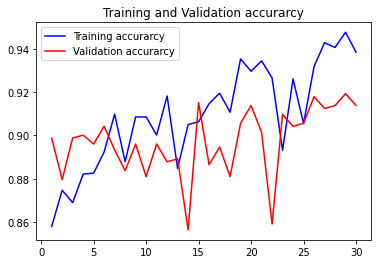

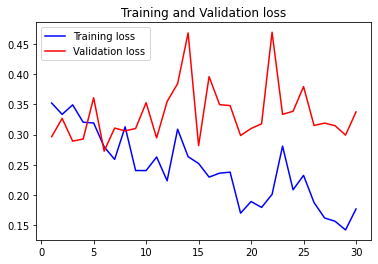

In [24]:
acc = model_dropout.history['accuracy']
val_acc = model_dropout.history['val_accuracy']
loss = model_dropout.history['loss']
val_loss = model_dropout.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [25]:
corr=[]
incorr=[]
corr_count=0
incorr_count=0

for i in range(len(y_test)):
    if(y_pred[i]==y_true[i]):
        corr.append(i)
        corr_count+=1
    else:
        incorr.append(i)
        incorr_count+=1
        
print("Found %d correct" %(corr_count))
print("Found %d incorrect " %(incorr_count))

Found 537 correct
Found 48 incorrect 


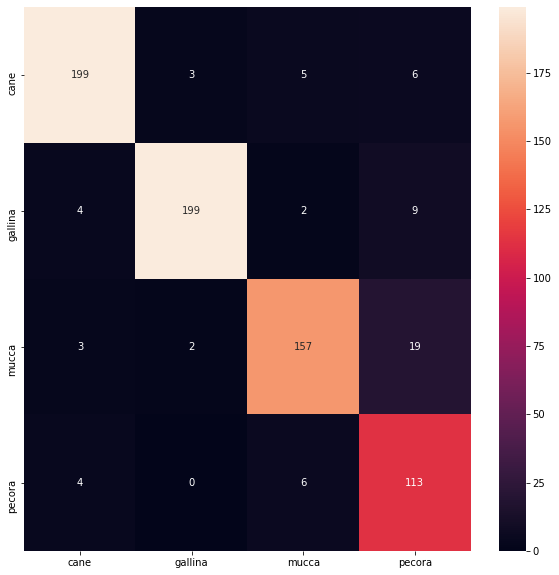

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
y_pred=model.predict(X_valid)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_valid,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
#plot the con mat
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(imagelabels))
ax.set_yticklabels(np.unique(imagelabels))
plt.show()

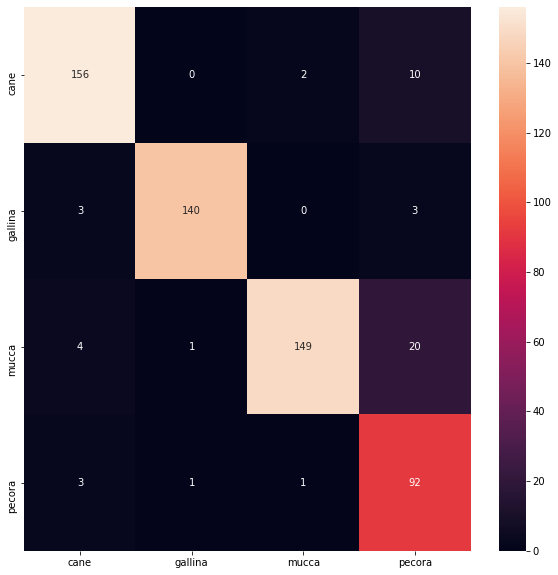

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
y_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(imagelabels))
ax.set_yticklabels(np.unique(imagelabels))
plt.show()